## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OrdinalEncoder,
    PowerTransformer,
    FunctionTransformer
)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

In [2]:
# Import dataset from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "rezafsihab1" # username from the json file
os.environ['KAGGLE_KEY'] = "cf34520590b27315f83e2f2c669404b4" # key from the json file

# Link dataset
!kaggle datasets download -d yasserh/customer-segmentation-dataset # api copied from kaggle
# link: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset/code

# Unzip file
!unzip /content/customer-segmentation-dataset.zip

 83% 18.0M/21.8M [00:01<00:00, 23.0MB/s]
100% 21.8M/21.8M [00:01<00:00, 17.3MB/s]
Archive:  /content/customer-segmentation-dataset.zip
  inflating: Online Retail.xlsx      


## Data Understanding

In [3]:
df = pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Drop missing values

In [6]:
# membuat tabel total persentasi missing value per featurenya
total_data = len(df)
data_nan = df.isna().sum().reset_index()
data_nan.columns = ['feature','missing_value']
data_nan['total_data'] = total_data
data_nan['percentage'] = round((data_nan['missing_value']/total_data)*100,3)
data_nan = data_nan.sort_values('percentage', ascending=False).reset_index(drop=True)
data_nan = data_nan[data_nan['percentage']>0]
data_nan

,feature,missing_value,total_data,percentage
0,CustomerID,135080,541909,24.927
1,Description,1454,541909,0.268


There are only two columns containing missing values: Description and CustomerID. Considering the uniqueness nature of CustomerID, it does not make sense to fill the missing values with another value, so we will just drop them. The remaining missing values in the Description column will be replaced with an empty string, so we can keep the rest of the information of those rows.

It is important to observe that after the removal of the missing values, a lot of data still remains in the dataset, so probably we won't have information loss problem.

In [7]:
df.drop(df[df["CustomerID"].isnull()].index, axis=0, inplace=True)
df["Description"] = df["Description"].fillna("")
df.isnull().sum().sum()

0

In [8]:
df.shape

(406829, 8)

### Duplicates Value

In [9]:
df.duplicated().sum()

5225

In [10]:
# dropping duplicate values
df.drop_duplicates(inplace=True)

In [11]:
print(df.duplicated().sum())
print(df.shape)

0
(401604, 8)


### Feature Selection

In [12]:
# extracting time related features from InvoiceDate

df["InvoiceDateDay"] = df["InvoiceDate"].dt.date
df["InvoiceDateTime"] = df["InvoiceDate"].dt.time
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceMonth"] = df["InvoiceDate"].dt.month
df["InvoiceMonthName"] = df["InvoiceDate"].dt.month_name()
df["InvoiceDay"] = df["InvoiceDate"].dt.day
df["InvoiceDayName"] = df["InvoiceDate"].dt.day_name()
df["InvoiceDayOfWeek"] = df["InvoiceDate"].dt.day_of_week
df["InvoiceWeekOfYear"] = df["InvoiceDate"].dt.weekofyear
df["InvoiceHour"] = df["InvoiceDate"].dt.hour

df["TotalValue"] = df["Quantity"] * df["UnitPrice"]

In [13]:
ref_date = df["InvoiceDateDay"].max() + timedelta(days=1)

df_customers = df.groupby("CustomerID").agg({
    "InvoiceDateDay": lambda x : (ref_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalValue": "sum"
}).rename(columns={
    "InvoiceDateDay": "Recency",
    "InvoiceNo": "Frequency",
    "TotalValue": "Monetary"
})

In [14]:
df_customers.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [15]:
feat = ['Recency','Frequency','Monetary']
dataset = df_customers[feat].copy()

## Modeling and Evaluation

### Scaling

In [16]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(dataset)

In [17]:
feats = list(dataset)
new_df = pd.DataFrame(data = X_std, columns = feats)
new_df.head()

,Recency,Frequency,Monetary
0,2.316568,-0.392056,-0.230420
1,-0.889050,0.393293,0.294055
2,-0.164560,-0.265527,-0.011717
3,-0.730258,-0.082279,-0.016547
4,2.167700,-0.326610,-0.189727


### Reduction with TSNE

In [18]:
from sklearn.manifold import TSNE

Xtsne = TSNE(n_components=2).fit_transform(X_std)
dftsne = pd.DataFrame(Xtsne)
dftsne.columns = ['x1','x2']
dftsne.head()

,x1,x2
0,-50.404530,64.534088
1,44.307213,-3.555577
2,-33.072987,-4.265908
3,11.883554,-30.380915
4,-53.977104,54.699928


### Best K

<Axes: >

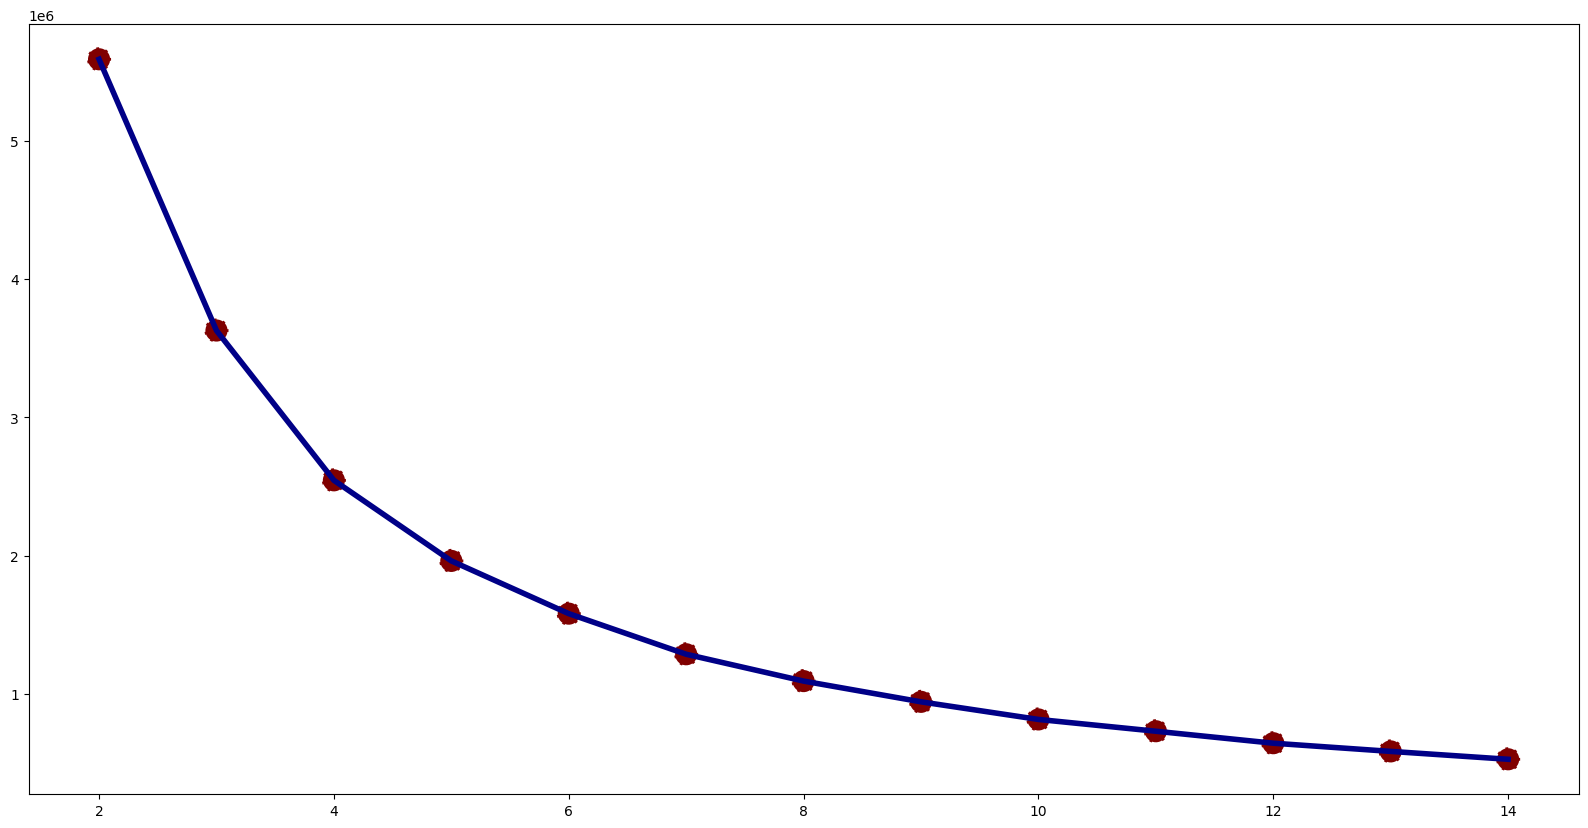

In [20]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(Xtsne)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 15), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 15), y=inertia, s=300, color='#800000',  linestyle='--')

#### Elbow

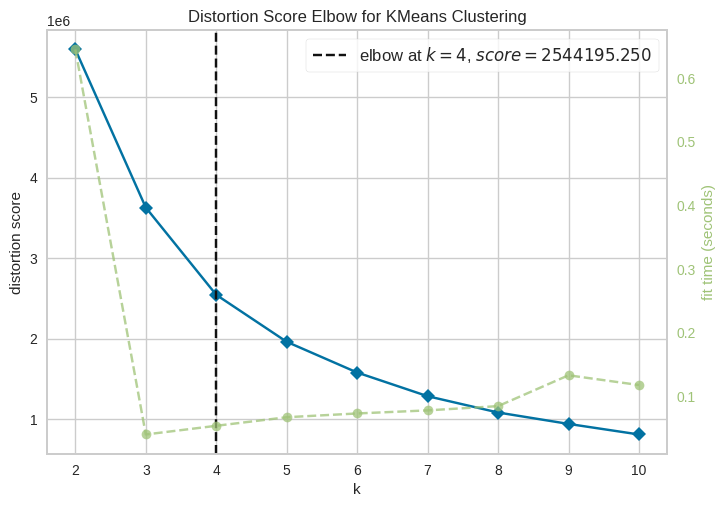

In [21]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(Xtsne)
Elbow_M.show()
plt.show()

#### silhouette score

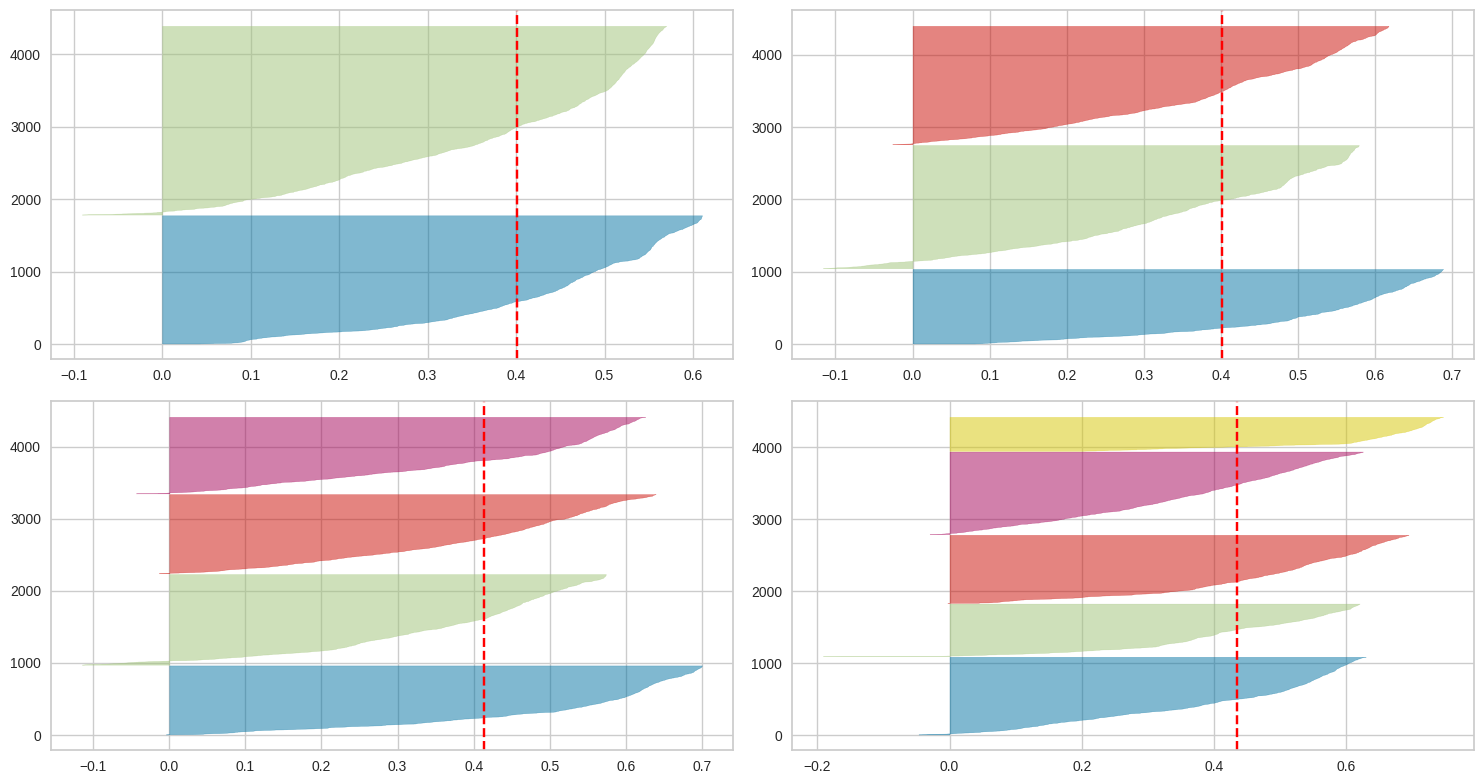

Skor siluet maksimum: 0.43514827
Jumlah cluster terbaik: 5


In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

n_clusters = [2, 3, 4, 5]  # Jumlah cluster yang ingin dievaluasi

fig, ax = plt.subplots(2, 2, figsize=(15, 8))

max_silhouette_score = float('-inf')
best_k = None

for i, k in enumerate(n_clusters):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(Xtsne)
    
    # Mendapatkan label cluster
    labels = km.labels_
    
    # Menghitung skor siluet rata-rata
    silhouette_avg = silhouette_score(Xtsne, labels)
    
    # Memperbarui skor siluet maksimum dan jumlah cluster terbaik
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        best_k = k

plt.tight_layout()
plt.show()

print("Skor siluet maksimum:", max_silhouette_score)
print("Jumlah cluster terbaik:", best_k)

## Clustering

In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(Xtsne)

KMeans(n_clusters=5, random_state=0)

In [36]:
dataset['clusters'] = kmeans.labels_
dftsne['clusters'] = kmeans.labels_
dataset.head()

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12346.0,326,2,0.00,1
12347.0,3,182,4310.00,3
12348.0,76,31,1797.24,0
12349.0,19,73,1757.55,2
12350.0,311,17,334.40,1


In [38]:
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dataset.describe(percentiles=perc)

,Recency,Frequency,Monetary,clusters
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,92.581199,91.858188,1893.531433,1.919488
std,100.772139,229.223566,8218.696204,1.425305
min,1.000000,1.000000,-4287.630000,0.000000
10%,5.000000,7.000000,144.919000,0.000000
20%,12.000000,14.000000,232.504000,0.000000
30%,22.000000,21.000000,334.657000,1.000000
40%,32.000000,29.000000,463.540000,2.000000
50%,51.000000,41.000000,644.070000,2.000000
60%,72.000000,58.000000,903.228000,2.000000


In [39]:
dataset.groupby('clusters').agg({
                            'Recency' : ['mean'],
                            'Frequency' : ['mean'],
                            'Monetary' : ['mean','median']
    
})

Recency   Frequency     Monetary          
                mean        mean         mean    median
clusters                                               
0          73.524059   52.674541   964.375400   632.040
1         281.588983   23.425847   388.584979   267.105
2          19.624074   43.058333   738.377038   602.835
3          15.196203  277.143460  6151.640105  2891.540
4         208.802469   28.950617   498.798643   311.650

In [40]:
dataset.head(3)

,Recency,Frequency,Monetary,clusters
CustomerID,,,,
12346.0,326,2,0.00,1
12347.0,3,182,4310.00,3
12348.0,76,31,1797.24,0


## Clustering Visualization

In [41]:
dftsne.head(2)

,x1,x2,clusters
0,-50.404530,64.534088,1
1,44.307213,-3.555577,3


<Axes: xlabel='x1', ylabel='x2'>

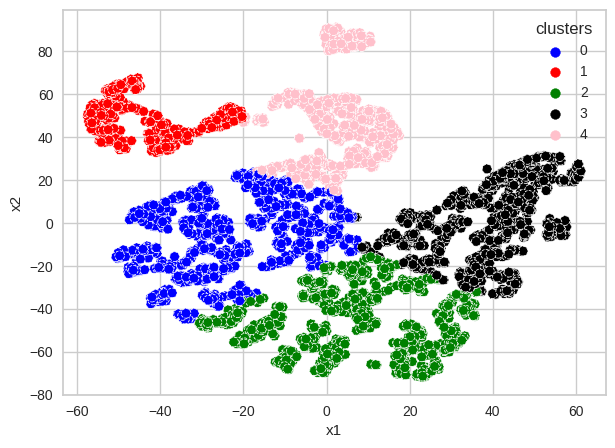

In [42]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="x1", y="x2",
    hue="clusters",
    palette=['blue','red','green','black','pink','orange'],
    linestyle='--',
    data=dftsne,
    ax=ax
)